In [1]:
from __future__ import division
from importlib import reload
from modules import * 
fig_savedir = '../data/figures/'

grid_params = {
    'y_height':   20,
    'x_width':    20,
    'walls':      False,
    'rho':        0,
    'maze_type':  'none',
    'port_shift': 'none'
}


agent_params = {
    'load_model':   True,
    'load_dir':     '../data/outputs/gridworld/MF{}{}training.pt'.format(grid_params['x_width'],grid_params['y_height']),
    'action_dims':  6, #=len(maze.actionlist)
    'lin_dims':     500,
    'batch_size':   1,
    'gamma':        0.98, #discount factor
    'eta':          5e-4,
    'temperature':  1,
    'use_EC':       False,
    'cachelim':     100, # memory limit should be ~75% of #actions x #states
    'state_type':   'conv'
}

run_dict = {
    'NUM_EVENTS':   150,
    'NUM_TRIALS':   5000,
    'print_freq':   1/10,
    'total_loss':   [[],[]],
    'total_reward': [],
    'val_maps':     [],
    'policies':     [{},{}],
    'deltas':       [],
    'spots':        [],
    'vls':          []
}

/home/annik/.local/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'actorcritic.AC_Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


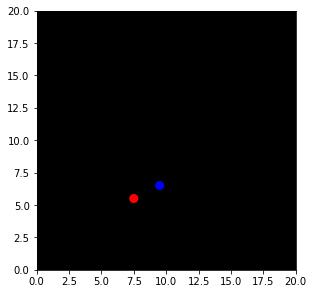

In [2]:
#make environment
maze = eu.gridworld(grid_params)
maze.set_rwd([(7,5)])  #([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])
env = eu.gymworld(maze) # openAI-like wrapper 

#update agent params dictionary with layer sizes appropriate for environment 
agent_params = sg.gen_input(maze, agent_params)
MF,opt = ac.make_agent(agent_params)
gp.make_env_plots(maze,env=True)

agent_params['cachelim'] = int(0.5*np.prod(maze.grid.shape))

EC = ec.ep_mem(MF,agent_params['cachelim']) 


In [3]:
# make function to run simulation 
def run_trials(run_dict, use_EC, **kwargs):
    save_data  = kwargs.get('save', True)
    NUM_TRIALS = 30#run_dict['NUM_TRIALS']
    NUM_EVENTS = run_dict['NUM_EVENTS']
    
    blocktime = time.time()
    
    if use_EC:
        # clear EC
        EC.reset_cache()
        # make data frames to store trial info
        add_mem_dict     = {} #dictionary of items which get put into memory cache
        compare_policies = {}
        rpe              = {}
        
        timestamp = 0
        tslr      = 100000
        reward    = 0
        
        for trial in range(NUM_TRIALS):
            trialstart_stamp = timestamp

            reward_sum   = 0
            v_last       = 0

            env.reset() 

            state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))
            MF.reinit_hid() #reinit recurrent hidden layers

            for event in range(NUM_EVENTS):
                #compute confidence in MFC
                MF_cs = EC.make_pvals(tslr,envelope=10)
                
                # pass state through EC module
                policy_, value_, lin_act_ = MF(state, temperature = 1)
                # get activity of linear layer to pass as EC dictionary key
                lin_act = tuple(np.round(lin_act_.data[0].numpy(),4))
                
                if event is not 0:
                    # generate policy from relevant entry from EC
                    ec_pol = torch.from_numpy(EC.recall_mem(lin_act, timestamp, env=150))
                    
                    # choose a policy for behaviour by sampling with probability 
                    # determined by MF confidence score
                    pol = np.random.choice([policy_, ec_pol], p=[MF_cs, 1-MF_cs])
                else:
                    pol = policy_
                
                # select action from chosen policy
                choice, policy, value = ac.select_action(MF,pol, value_)
                
                add_mem_dict['state'] = maze.cur_state
                #compute eligibility trace/rpe approximation
                delta = reward + agent_params['gamma']*value - v_last 
                
                rpe[maze.cur_state] = delta
                
                # step to next state
                if event < NUM_EVENTS: 
                    next_state, reward, done, info = env.step(choice)
                
                
                if event is not 0:
                    # increase time since last reward counter
                    if reward == 1:
                        tslr = 0
                    else:
                        tslr += 1
                    
                    # keep track of policies generated for each state 
                    compare_policies[maze.cur_state] = [[policy.data.numpy()],[ec_pol.data.numpy()]]
                    
                MF.rewards.append(reward)
                
                # write to memory buffer 
                add_mem_dict['activity']  = lin_act
                add_mem_dict['action']    = choice
                add_mem_dict['delta']     = delta
                add_mem_dict['timestamp'] = timestamp            
                
                #add event to memory cache
                EC.add_mem(add_mem_dict)
                
                state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))
                reward_sum += reward

                v_last = value
                timestamp += 1
            
            # when using EC, no weight updates 
            del MF.rewards[:]
            del MF.saved_actions[:]
            #p_loss, v_loss = ac.finish_trial(MF,agent_params['gamma'],opt)

            if save_data:
                #value_map = ac.generate_values(maze,MF)
                #run_dict['total_loss'][0].append(p_loss.data[0])
                #run_dict['total_loss'][1].append(v_loss.data[0])
                run_dict['total_reward'].append(reward_sum)
                #run_dict['val_maps'].append(value_map.copy())
                #run_dict['deltas'].append(track_deltas)
                #run_dict['spots'].append(track_spots)
                #run_dict['vls'].append(visited_locs)

            if trial ==0 or trial%10==0 or trial == NUM_TRIALS-1:
                print("[{0}]  Trial {1} TotRew = {2} ({3:.3f}s)".format(time.strftime("%H:%M:%S", time.localtime()), trial+1, reward_sum,time.time()-blocktime)) #print("[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)) 
                blocktime = time.time()
        return compare_policies, rpe

    else:
        rpe = {}
        for trial in range(NUM_TRIALS):
            reward_sum   = 0
            v_last       = 0
            track_deltas = []
            track_spots  = []
            visited_locs = []

            env.reset() 
            state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))
            MF.reinit_hid() #reinit recurrent hidden layers

            for event in range(NUM_EVENTS):
                policy_, value_ = MF(state, agent_params['temperature'])[0:2]
                choice, policy, value = ac.select_action(MF,policy_, value_)

                if event < NUM_EVENTS: 
                    next_state, reward, done, info = env.step(choice)

                MF.rewards.append(reward)
                #compute eligibility trace/rpe approximation
                delta = reward + agent_params['gamma']*value - v_last  
                state = ac.Variable(ac.torch.FloatTensor(sg.get_frame(maze)))
                rpe[maze.cur_state] = delta
                
                reward_sum += reward
                v_last = value

            p_loss, v_loss = ac.finish_trial(MF,agent_params['gamma'],opt)

            if save_data:
                #value_map = ac.generate_values(maze,MF)
                run_dict['total_loss'][0].append(p_loss.data[0])
                run_dict['total_loss'][1].append(v_loss.data[0])
                run_dict['total_reward'].append(reward_sum)
                #run_dict['val_maps'].append(value_map.copy())
                #run_dict['deltas'].append(track_deltas)
                #run_dict['spots'].append(track_spots)
                #run_dict['vls'].append(visited_locs)

            if trial ==0 or trial%100==0 or trial == NUM_TRIALS-1:
                print("[{0}]  Trial {1} TotRew = {2} ({3:.3f}s)".format(time.strftime("%H:%M:%S", time.localtime()), trial+1, reward_sum,time.time()-blocktime)) #print("[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)) 
                blocktime = time.time()
        return rpe

In [4]:
# run simulation with parameters defined in run_dict 
compare_policies, rpe = run_trials(run_dict, True)
#rpe = run_trials(run_dict, False)

../memory/episodic.py:58: RuntimeWarning: overflow encountered in cosh
  return np.round(1 / np.cosh(p / self.memory_envelope), 8)
../rl_network/actorcritic.py:286: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return action.data[0], policy_.data[0], value_.data[0]


[15:17:52]  Trial 1 TotRew = 0 (0.940s)
[15:18:45]  Trial 11 TotRew = 0 (52.430s)
[15:19:44]  Trial 21 TotRew = 0 (59.507s)
[15:20:40]  Trial 30 TotRew = 0 (55.801s)


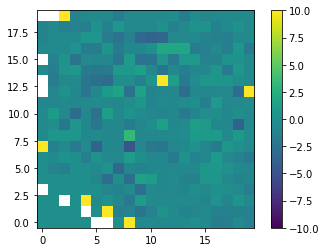

In [59]:
# plot RPE calculated at each state

x = np.empty((20,20))
for i in rpe.keys():
    #print(i, rpe[i].numpy()[0])
    x[i[1], i[0]] = rpe[i].numpy()[0]

plt.imshow(x, vmin=-10, vmax=10) 
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()


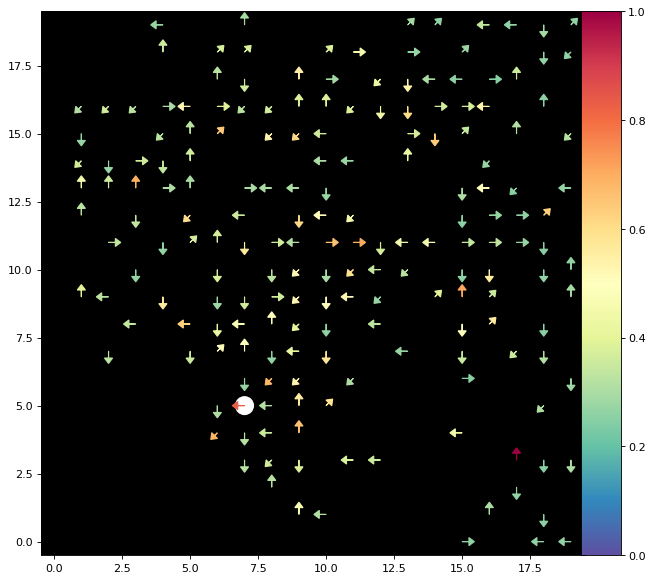

In [58]:
## plot most likely action in policies produced by EC

fig = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
cmap = plt.cm.Spectral_r
cNorm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap = cmap)

ax1 = fig.add_axes([0.04, 0, 0.85, 0.85])
axc = fig.add_axes([0.8, 0, 0.05, 0.85])

cb1 = colorbar.ColorbarBase(axc, cmap = cmap, norm = cNorm)
ax1.imshow(maze.grid, vmin=0, vmax=1, cmap='bone', interpolation='none')
ax1.add_patch(patches.Circle(maze.rwd_loc[0], 0.35, fc='w'))

for entry in compare_policies.keys():
    x = entry[0]
    y = entry[1]
    
    ec_policy = compare_policies[entry][1][0] 
    action = np.argmax(ec_policy)
    prob = max(ec_policy)
    
    dx1, dy1, head_w, head_l = gp.make_arrows(action,prob)
    if prob > 1/4:
        if (dx1, dy1) == (0,0):
            pass
        else:
            colorVal1 = scalarMap.to_rgba(prob)
            ax1.arrow(x,y, dx1, dy1, head_width=0.3, head_length=0.2, color = colorVal1)
    else:
        pass

ax1.invert_yaxis()
plt.show()
plt.close()

In [ ]:
#ac.torch.save(MF,agent_params['load_dir'])